## TP Detección de fraude
Dataset descargado de:  https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve


In [2]:
fraud_dataset = pd.read_csv('./data/PS_20174392719_1491204439457_log.csv')

In [4]:
fraud_dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


* step: represents a unit of time where 1 step equals 1 hour
* type: type of online transaction
* amount: the amount of the transaction
* nameOrig: customer starting the transaction
* oldbalanceOrg: balance before the transaction
* newbalanceOrig: balance after the transaction
* nameDest: recipient of the transaction
* oldbalanceDest: initial balance of recipient before the transaction
* newbalanceDest: the new balance of recipient after the transaction
* isFraud: fraud transaction

In [5]:
fraud_dataset.shape

(6362620, 11)

In [6]:
#Chequear si hay nulos
fraud_dataset.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
#Dtype de las columnas
fraud_dataset.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

### Distribución de variables

/Users/mtaglio/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='step', ylabel='Density'>

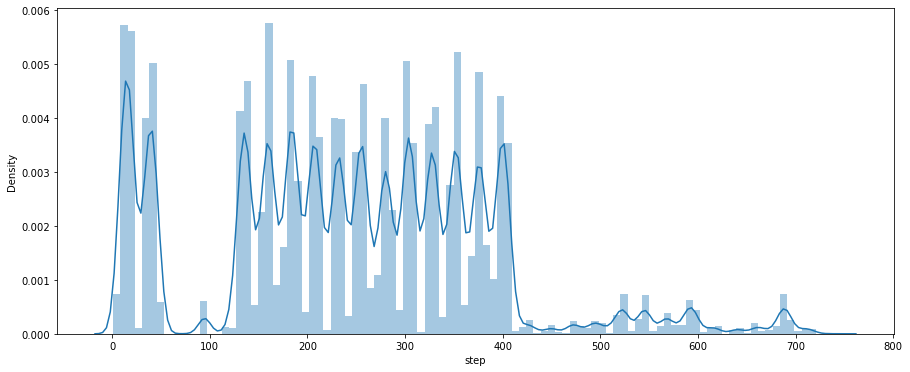

In [8]:
fraud_dataset['step'].value_counts()
plt.figure(figsize=(15,6))
sns.distplot(fraud_dataset['step'],bins=100)

In [15]:
print('Distribución de la variable type')
print(fraud_dataset['type'].value_counts())

type = fraud_dataset.type.value_counts()
transaction = type.index
quantity = type.values

figure = px.pie(fraud_dataset,
               values = quantity,
               names = transaction,
               hole = .3,
               title = 'Distribución de la variable type')
figure.show()

Distribución de la variable type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


<AxesSubplot:xlabel='type', ylabel='amount'>

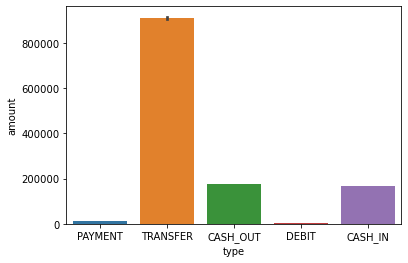

In [9]:
sns.barplot(x='type',y='amount',data=fraud_dataset)

La transacción con más observaciones es CASH_OUT seguida de PAYMENT.  Las operaciones con montos más altos son de tipo TRANSFER.

/Users/mtaglio/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



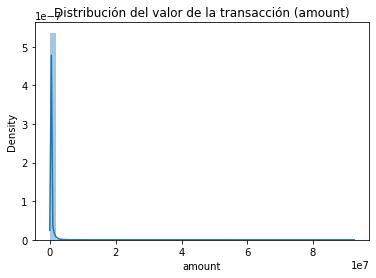

In [19]:
fraud_dataset['amount'].value_counts()
fig = plt.figure()
sns.distplot(fraud_dataset['amount'])
plt.title('Distribución del valor de la transacción (amount)')
plt.show(fig)

Distribución asimétrica negativa (left-skewed).

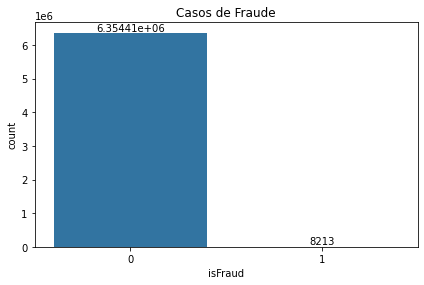

In [21]:
#Distribución variable de salida isFraud
fig = plt.figure()
ax = sns.countplot(x='isFraud', data=fraud_dataset)
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.title('Casos de Fraude')
plt.show(fig)


In [27]:
fraud_dataset['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

Aproximadamente un 0,13% de las transacciones fueron clasificadas como fraude. Como se puede ver en el gráfico el dataset no está balanceado.

### Correlaciones

<AxesSubplot:>

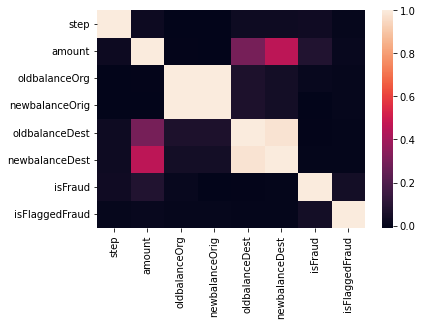

In [34]:
#Chequear correlaciones de las features con la variable de salida isFraud
heatmap(fraud_dataset.corr())

In [24]:
fraud_dataset.corr().unstack().sort_values(ascending=False).drop_duplicates()

step            step              1.000000
oldbalanceOrg   newbalanceOrig    0.998803
newbalanceDest  oldbalanceDest    0.976569
                amount            0.459304
amount          oldbalanceDest    0.294137
                isFraud           0.076688
newbalanceOrig  oldbalanceDest    0.067812
oldbalanceDest  oldbalanceOrg     0.066243
isFraud         isFlaggedFraud    0.044109
oldbalanceOrg   newbalanceDest    0.042029
newbalanceDest  newbalanceOrig    0.041837
step            isFraud           0.031578
                oldbalanceDest    0.027665
                newbalanceDest    0.025888
                amount            0.022373
isFlaggedFraud  amount            0.012295
isFraud         oldbalanceOrg     0.010154
isFlaggedFraud  oldbalanceOrg     0.003835
newbalanceOrig  isFlaggedFraud    0.003776
isFlaggedFraud  step              0.003277
newbalanceDest  isFraud           0.000535
oldbalanceDest  isFlaggedFraud   -0.000513
isFlaggedFraud  newbalanceDest   -0.000529
amount     

Hay correlación alta entre oldbalanceOrg y newbalanceOrg y entre oldbalanceDest y newbalanceDest.

### Distribución de las transacciones fraudulentas por tipo

<AxesSubplot:xlabel='isFraud', ylabel='count'>

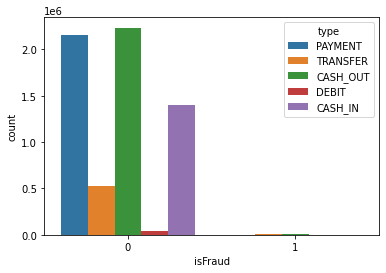

In [33]:
sns.countplot(x='isFraud',data=fraud_dataset,hue='type')

Las transacciones de tipo CASH_OUT y PAYMENT concentran la mayor cantidad de fraude.

### Preparación de datos

Variables categóricas: type, nameOrig, nameDest, isFraud, isFlaggedFraud, 
Variables numéricas: amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, step

In [35]:
fraud_dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
type_new = pd.get_dummies(fraud_dataset['type'],drop_first=True)

In [6]:
fraud_dataset = pd.concat([fraud_dataset,type_new],axis=1)

In [6]:
fraud_dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,1,0


### Train baseline model

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [7]:
X = fraud_dataset[['step','CASH_OUT','DEBIT','TRANSFER', 'PAYMENT','amount', 'oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y= fraud_dataset['isFraud']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [10]:
#Train Logistic Regression baseline model
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [28]:
lr_preds = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)

In [29]:
print('Area bajo la curva ROC (test):',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
print('Area bajo la curva ROC (train):',np.round(roc_auc_score(y_train,lr.predict_proba(X_train)[:,1]),4))
precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);
print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))
print(classification_report(y_test, lr_preds))

Area bajo la curva ROC (test): 0.885
Area bajo la curva ROC (train): 0.8874
Area bajo la curva Precision-Recall: 0.4112
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.37      0.43      0.40      2435

    accuracy                           1.00   1908786
   macro avg       0.68      0.72      0.70   1908786
weighted avg       1.00      1.00      1.00   1908786



In [18]:
y_test.value_counts()

0    1906351
1       2435
Name: isFraud, dtype: int64

El dataset está visiblemente desbalanceado. Hay únicamente 2435 casos de fraude en el test set. 
El modelo baseline arroja una precisión de 0.37 y un recall de 0.43, esto es hay una tasa bastante alta de falsos positivos y de falsos negativos. 
Es importante para este problema que el recall sea alto aun si esto implica sacrificar precisión. Es preferible cometer errores de tipo I, tener falsos positivos, casos erróneamente etiquetados como fraude, que cometer errores de tipo II, esto es, dejar pasar casos que son fraude.

En el siguiente paso vamos a trabajar con balanceo del dataset

### Balancear el dataset

1) probar distintas técnicas como oversampling, undersampling y Logistic regression con optimización.
2) mover el threshold (default = 0.5)

In [20]:
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts())
print('\nClases test:')
print(y_test.value_counts())

Entrenamiento: (4453834, 10)
Testeo: (1908786, 10)

Clases train:
0    4448056
1       5778
Name: isFraud, dtype: int64

Clases test:
0    1906351
1       2435
Name: isFraud, dtype: int64


#### 1. Logistic regression CV: con optimización LBGFS y 10 folds

In [21]:
from sklearn.linear_model import LogisticRegressionCV

In [30]:
lr_cv = LogisticRegressionCV(scoring='f1', cv=10)
lr_cv.fit(X_train, y_train)

/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegressionCV(cv=10, scoring='f1')

In [32]:
y_pred = lr_cv.predict(X_test)
y_proba = lr_cv.predict_proba(X_test)

In [33]:
print(classification_report(y_test, y_pred))
print('Area bajo la curva ROC (test):',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
print('Area bajo la curva ROC (train):',np.round(roc_auc_score(y_train,lr_cv.predict_proba(X_train)[:,1]),4))
precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);
print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.39      0.43      0.41      2435

    accuracy                           1.00   1908786
   macro avg       0.69      0.72      0.70   1908786
weighted avg       1.00      1.00      1.00   1908786

Area bajo la curva ROC (test): 0.885
Area bajo la curva ROC (train): 0.8873
Area bajo la curva Precision-Recall: 0.4117


#### 2. Undersampling

In [10]:
from imblearn.under_sampling import RandomUnderSampler

In [11]:
#selecciono número de muestras igual al de la clase minoritaria
undersampler = RandomUnderSampler(sampling_strategy = "majority")
X_train_us, y_train_us = undersampler.fit_resample(X_train, y_train)

print("training set con undersampling")
print(y_train_us.value_counts())
print()
print("Test set")
print(y_test.value_counts())

training set con undersampling
0    5778
1    5778
Name: isFraud, dtype: int64

Test set
0    1906351
1       2435
Name: isFraud, dtype: int64


In [163]:
lr_us = LogisticRegression()
lr_us.fit(X_train_us, y_train_us)

LogisticRegression()

In [164]:
y_pred = lr_us.predict(X_test)
y_proba = lr_us.predict_proba(X_test)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95   1906351
           1       0.01      0.88      0.03      2435

    accuracy                           0.91   1908786
   macro avg       0.51      0.90      0.49   1908786
weighted avg       1.00      0.91      0.95   1908786

Area bajo la curva ROC (test): 0.9571
Area bajo la curva ROC (train): 0.9607
Area bajo la curva Precision-Recall: 0.5276


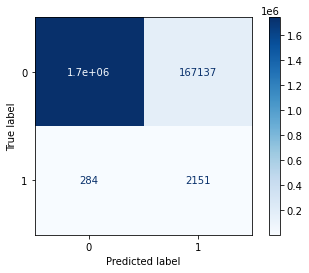

In [165]:
print(classification_report(y_test, y_pred))
print('Area bajo la curva ROC (test):',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
print('Area bajo la curva ROC (train):',np.round(roc_auc_score(y_train,lr_us.predict_proba(X_train)[:,1]),4))
precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);
print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))
plot_confusion_matrix(lr_us,X_test,y_test,cmap='Blues');


Resultados con undersampling: 
* alta cobertura o recall, o sea mayor porcentaje de casos que cubrimos con nuestra clasificación de la transacción como fraude.
* baja precisión: el porcentaje del total de casos que acertamos cuando decimos que una transacción es fraude.
El modelo es muy preciso para clasificar casos que no son fraude. Pero hay una gran cantidad de falsos positivos, el modelo clasifica como fraude casos que no lo son. En contraparte, hay una baja cantidad de falsos negativos, casos que son efectivamente fraude pero que el modelo no los clasifica como tal. 


#### 3. Oversampling
Samplear observaciones de la clase minoritaria con reposición

In [16]:
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_os.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
0    4448056
1    4448056
Name: isFraud, dtype: int64

Composición del test set:
0    1906351
1       2435
Name: isFraud, dtype: int64


In [49]:
lr_os = LogisticRegression()
lr_os.fit(X_train_os, y_train_os)

LogisticRegression()

In [50]:
y_pred = lr_os.predict(X_test)
y_proba = lr_os.predict_proba(X_test)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95   1906351
           1       0.01      0.88      0.02      2435

    accuracy                           0.91   1908786
   macro avg       0.51      0.90      0.49   1908786
weighted avg       1.00      0.91      0.95   1908786

Area bajo la curva ROC (test): 0.9571
Area bajo la curva Precision-Recall: 0.5269


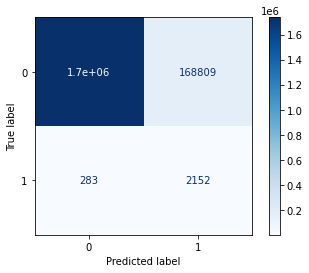

In [51]:
print(classification_report(y_test, y_pred))
print('Area bajo la curva ROC (test):',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);
print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))
plot_confusion_matrix(lr_os,X_test,y_test,cmap='Blues');

Resultados con oversampling:

Los resultados son muy similares a los obtenidos con undersampling. 

#### Entrenamiento con árboles de decisión y ensambles

In [169]:
#Decision tree classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt = DecisionTreeClassifier(max_depth=3, criterion='entropy')
dt.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [21]:
#plt.figure(figsize=(15,8))
#plot_tree(dt, feature_names=X_train.columns)

In [170]:
y_pred = dt.predict(X_test)
y_proba = dt.predict_proba(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.71      0.69      0.70      2435

    accuracy                           1.00   1908786
   macro avg       0.86      0.84      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786

Area bajo la curva ROC (test): 0.9473
Area bajo la curva ROC (train): 0.9495
Area bajo la curva Precision-Recall: 0.6257


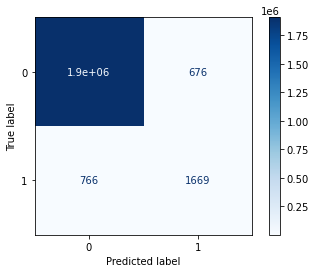

In [171]:
print(classification_report(y_test, y_pred))
print('Area bajo la curva ROC (test):',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
print('Area bajo la curva ROC (train):',np.round(roc_auc_score(y_train,dt.predict_proba(X_train)[:,1]),4))

precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);
print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))
plot_confusion_matrix(dt,X_test,y_test,cmap='Blues');

Sube precision y recall: 
El modelo predice perfectamente cuando los casos no son fraude. 
Predice con mejor precisión los casos que sí son fraude. Menos tasa de falsos positivos,  o sea casos que son etiquetados incorrectamente como fraude. 
Se duplican los falsos negativos, en comparación con los modelos de logistic regression.


Random forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=10, random_state=0)

In [32]:
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.98      0.79      0.87      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.89      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786

Area bajo la curva ROC (test): 0.973
Area bajo la curva ROC (train): 1.0
Area bajo la curva Precision-Recall: 0.9301


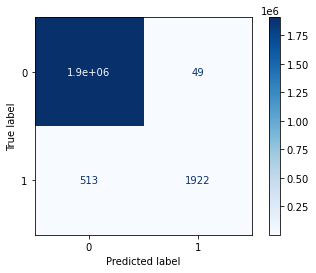

In [33]:
print(classification_report(y_test, y_pred))
print('Area bajo la curva ROC (test):',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
print('Area bajo la curva ROC (train):',np.round(roc_auc_score(y_train,rf.predict_proba(X_train)[:,1]),4))

precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);
print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))
plot_confusion_matrix(rf,X_test,y_test,cmap='Blues');

Extra trees classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
et = RandomForestClassifier(n_estimators=10, random_state=42)
et.fit(X_train, y_train)

#### Test manual

In [150]:
y_hat = np.where(y_pred == 1)
y_hat_array = np.array(y_hat)
y_hat_list = y_hat_array.tolist()

(array([    420,     548,     952, ..., 1905441, 1907413, 1908622]),)

In [158]:
y_hat_list

[[420,
  548,
  952,
  1816,
  2086,
  2591,
  3762,
  4030,
  4560,
  5063,
  7526,
  8723,
  9119,
  9391,
  9930,
  11655,
  11690,
  12526,
  12574,
  15956,
  16506,
  16771,
  16809,
  17934,
  18101,
  18257,
  18353,
  18655,
  18932,
  19736,
  20296,
  22280,
  24802,
  24964,
  25643,
  26440,
  26608,
  27182,
  29589,
  30630,
  30781,
  30827,
  34675,
  36168,
  37564,
  38543,
  39905,
  40054,
  43761,
  45039,
  46331,
  46745,
  47115,
  47307,
  49259,
  49903,
  50119,
  51838,
  51848,
  52765,
  55441,
  56135,
  57350,
  58919,
  59907,
  60259,
  60481,
  61611,
  62778,
  62839,
  63243,
  65702,
  65733,
  68903,
  69702,
  70135,
  70516,
  71200,
  71726,
  72076,
  72093,
  72756,
  72797,
  73473,
  74355,
  75487,
  75854,
  76821,
  77829,
  78734,
  78960,
  79326,
  79921,
  81273,
  82009,
  82637,
  82817,
  83962,
  86321,
  90516,
  90548,
  90916,
  93198,
  93705,
  94123,
  94370,
  94935,
  95277,
  96436,
  97087,
  97454,
  98238,
  99204,
 

In [161]:
y_test.iloc[16771]

1

In [160]:
y_pred[16771]

1